In [240]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
import math

In [241]:
from numpyNN import sample_data

## MLP


In [270]:
class mlp:
    def __init__(self, layers,opt_act , opt_init, opt_optimizer):
        """
        """
        self.layers = layers
        self.num_layers = len(layers)        
        self.w = [np.random.randn(layers[i-1], layers[i]) 
                        for i in range(1, self.num_layers)]
        self.b = [np.random.randn(1, layers[i]) 
                       for i in range(1, self.num_layers)]

        if opt_init == 'he':
            self.w = self.he_init(self.w)
        elif opt_init == 'xavier':
            self.w = self.xavier_init(self.w)
        # Define the width of the neural network
        self.l =self.num_layers 
        self.opt = opt_act
        self.debug = 0
        self.vdw = [np.zeros((layers[i-1], layers[i])) 
                        for i in range(1, self.num_layers)]
        self.sdw = [np.zeros((layers[i-1], layers[i])) 
                        for i in range(1, self.num_layers)]
        self.vdb = [np.zeros((1, layers[i])) 
                       for i in range(1, self.num_layers)]
        self.sdb = [np.zeros((1, layers[i]))
                       for i in range(1, self.num_layers)]
        
        self.optimizer = opt_optimizer

    def xavier_init(self,weights):
        for i in range(len(weights)):
            n = weights[i].shape[0]
            m = weights[i].shape[1]
            lower, upper = -(math.sqrt(6.0) / math.sqrt(n + m)), (math.sqrt(6.0) / math.sqrt(n + m))
            weights[i] = lower + weights[i] * (upper - lower)
        return weights
    
    def he_init(self,weights):
        for i in range(len(weights)):
            n= weights[i].shape[0]
            std = math.sqrt(2.0/n)
            weights[i] = weights[i] * std 
        return weights
    
    def predict(self, X):
        """
        Get the prediction output of the  model.
        :param X: input data to be fed to the MLP
        :return: final output result
        """
        # Check the dimensions of X
        # append ones vector in the beginning of X
        a = X
        self.z_intermediate = []
        # how can we vecotrize this?
        for i in range(self.l - 1): 
            # We are keeping the weights and the bias separate - for simplicity 
            z = (np.dot(a,self.w[i]) + self.b[i])
            # Also in the loop make sure that the a[0] is ones
            self.z_intermediate.append(z)
            if i != self.l - 2:
                if self.opt == 'linear':
                    a = z
                elif self.opt == 'sigmoid':
                    a = self.activation('sigmoid',z)
                elif self.opt == 'relu':
                    a = self.activation('relu',z)
                elif self.opt == 'tanh':
                    a = self.activation('tanh',z)
            else:
                a = self.activation('sigmoid',z)
       
        out = a
        return out

    def activation(self, opt, value):
        if opt == 'sigmoid':
            return  1/(1+np.exp(-value))
        if opt == 'relu':
            return np.maximum(0,value)
        if opt == 'tanh':
            return np.tanh(value)
        else:
            print("Not a valid activation")
            
            
            
    def loss_function(self, y_true, y_pred):
        """
        Loss function : MSE loss
        :param y_true:  ground truth labels
        :param y_pred: prediction results
        :return:  computed loss value
        """
        n = y_pred.shape[0]
        cost = (1. / (2 * n)) * np.sum((y_true - y_pred) ** 2)
        return cost
    
    def cross_entropy(self, y_true, y_pred):
        n = y_pred.shape[0]
        cost = (1/n) * np.sum(-1 * (y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)))
        return cost

    def reluDerivative(self,a):
        a[a<=0] = 0
        a[a>0] = 1
        return a
    
    def tanhDerivative(self,a):
        return 1 - a**2
    
    def opt_gd_momentum(self, vdx,dx):
        beta = 0.99
        v = beta * vdx + (1-beta) * dx
        return v
    
    def opt_adam(self, xdx, dx, s):
        beta1: float = 0.9
        beta2: float = 0.99
        if s == 0:
            out = beta1 * xdx + (1-beta1) * dx
        else:
            out = beta2 * xdx + (1-beta2) * np.square(dx)
        return out
        
        
    def optimization(self, X, Y, learning_rate):
        """
        Optimization using gradient descent and backpropagation
        :param X: input data
        :param Y: ground truth labels
        :param learning_rate: learning_rate for gradient descent
        :return:  loss value
        """
        # This is the first forward pass 
        y_pred = self.predict(X)
        # Calculate the loss for the fist forward pass
        loss = self.loss_function(Y, y_pred)
        
        ########################################
        # Backpropagation:
        ########################################
        # backpropagation and gradient calculation
        # The gradient for the output layer is (y_pred - y)
        # And the gradient of the activation wrt to z would (1-output)
        
        ## ---- Gradient of the last layer: -----
        #delta = (y_pred-Y) * y_pred * (1-y_pred)
        # update the weights of the second last layer 
        
        # update delta according to the equation from the notes 
        
        for l in reversed(range(len(self.w))):
            if l == len(self.w) -1:
                da_dz = y_pred * (1-y_pred)                                     # Dimensions: (Data x nL)
                dL_da = y_pred - Y                                              # Dimensions: (Data x nL)
                delta = dL_da * da_dz                                           # Dimensions: (Data x nl)
            else:
                if self.debug == 1:
                    ##########################################################
                    print("-------------[Layer {}]--------------".format(l))
                    print("z shape: ", self.z_intermediate[l-1].shape)
                    print("Delta shape: ", delta.shape)
                    print("w shape: ", self.w[l].shape)
                    print("w shape: ", self.b[l].shape)
                    ##########################################################
                if self.opt == 'linear':
                    da_dz = 1                                                   # Dimensions: (Data x nl)
                elif self.opt == 'sigmoid':
                    da_dz = self.activation('sigmoid',self.z_intermediate[l-1]) * (1-self.activation('sigmoid',self.z_intermediate[l-1])) # Dimensions: (Data x nl)
                elif self.opt == 'relu':
                    da_dz =  self.reluDerivative(self.activation('relu',self.z_intermediate[l-1]))      # Dimensions: (Data x nl)
                elif self.opt == 'tanh':
                    da_dz =  self.tanhDerivative(self.activation('tanh',self.z_intermediate[l-1]))      # Dimensions: (Data x nl)                          
            if self.opt == 'linear':
                dz_dw = self.z_intermediate[l-1]                                                        # Dimensions: (Data x nl)
            elif self.opt == 'sigmoid':
                dz_dw = self.activation('sigmoid',self.z_intermediate[l-1])                             # Dimensions: (Data x nl)
            elif self.opt == 'relu':
                dz_dw = self.activation('relu',self.z_intermediate[l-1])                                # Dimensions: (Data x nl)
            elif self.opt == 'tanh':
                dz_dw = self.activation('tanh',self.z_intermediate[l-1])                                # Dimensions: (Data x nl) 

            dL_dw = (1/X.shape[0]) * np.dot(dz_dw.T,delta)                                              # Dimensions: (nl x nl+1)
            dL_db = (1/X.shape[0]) * np.sum(delta,axis=0).reshape(1,dL_dw.shape[1])                     # Dimensions: (1 x nl+1)
            
            if self.debug == 1:
                ##########################################################
                print("z shape: ", self.z_intermediate[l-1].shape)
                print("dz_dw shape: ",dz_dw.shape)
                print("Delta shape: ", delta.shape)
                print("dL_dw shape: ", dL_dw.shape)
                print("w shape: ", self.w[l].shape)
                print("dL_db shape: ", dL_db.shape)
                ########################################################## 

            if self.optimizer == 'momentum':
                self.vdw[l] = self.opt_gd_momentum(self.vdw[l], dL_dw)
                self.vdb[l] = self.opt_gd_momentum(self.vdb[l], dL_db)
                dL_dw = self.vdw[l]
                dL_db = self.vdb[l]
            elif self.optimizer == 'adam':
                self.vdw[l] = self.opt_adam(self.vdw[l], dL_dw, s=0)
                self.vdb[l] = self.opt_adam(self.vdb[l], dL_db, s=0)
                self.sdw[l] = self.opt_adam(self.sdw[l], dL_dw, s=1)
                self.sdb[l] = self.opt_adam(self.sdb[l], dL_db, s=1)
                dL_dw = self.vdw[l]/np.sqrt(self.sdw[l]+1e-7)
                dL_db = self.vdb[l]/np.sqrt(self.sdb[l]+1e-7)
                
                if self.debug == 1:
                    ##########################################################
                    print("-------------------[Momentum]---------------------")
                    print("vdw shape: ", self.vdw[l].shape)
                    print("vdb shape: ",self.vdb[l].shape)
                    print("dL_dw shape: ", dL_dw.shape)
                    print("dL_db shape: ", dL_db.shape)
                    ########################################################## 
                
            # Updates
            self.w[l] -= learning_rate * dL_dw                                  # Dimensions: (nl x nl+1)
            self.b[l] -= learning_rate * dL_db                                  # Dimensions: (1 x nl+1)
                    
            dz_da_l_m_1 = self.w[l].T                                           # Dimensions: (nl+1 x nl)
            dL_da = np.dot(delta, dz_da_l_m_1)                                  # Dimensions: (Data x nl+1)(nl+1 x nl)
            delta = dL_da * da_dz
        return loss


    def train(self, x_train, y_train, x_test, y_test,learning_rate, epochs, print_every=10, plot_every=10):
        """
        Trains the MLP network
        :param x_train:  training input data
        :param y_train: training true label
        :param x_test: validation input data
        :param y_test: validation true label
        :param epochs: number of training epochs
        :param print_every: the number of epochs by which the loss reported
        :param plot_every: the number of epochs for plotting decision boundry
        :return: the loss logs
        """

        train_losses = []
        test_losses = []

        for e in range(epochs):
            # Calcualate the initial loss: using the initilized weights. 
            # And update the weights of the NN according to the loss optained by "train data"
            train_loss = self.optimization(x_train, y_train, learning_rate)
            #print("e",train_loss)
            # Calculate the loss on the test input
            pred_test = self.predict(x_test)
            test_loss = self.loss_function(y_test, pred_test)

            # Store the train loss
            train_losses.append(train_loss)
            test_losses.append(np.mean(test_loss))
            

            # For each epoch print the train and test loss
            if print_every>0 and e % print_every == 0:
                print('Epoch {} / {} | train loss: {} | val loss : {}  '.format(
                    e, epochs, np.round(train_loss, 3), np.round(test_loss, 3)))

            
            if plot_every>0 and e % plot_every == 0:
                # Call this fucntion and pass training features, output and prediction function of the NN
                plot_decision_boundary(x_train,y_train, self.predict)
                plt.show()
                time.sleep(0.2) # comment this line
                display.display(plt.gcf())
                display.clear_output(wait=True)

        X = np.concatenate([x_train, x_test], axis=0)
        Y = np.concatenate([y_train, y_test], axis=0)
        plot_decision_boundary(X, Y, self.predict)

        train_logs = {'epochs': epochs,
                      'train_loss': train_losses,
                      'test_loss': test_losses,
                      }
        return train_logs

## Visualization
### Loss curve

In [243]:
def plot_loss(train_logs):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    t = np.arange(len(train_logs['train_loss']))
    plt.plot(t, train_logs['train_loss'], label='train_loss', lw=3)
    plt.plot(t, train_logs['test_loss'], label='test_loss', lw=3)
    plt.grid(1)
    plt.xlabel('epochs',fontsize=15)
    plt.ylabel('loss value',fontsize=15)
    plt.legend(fontsize=15)

### Decision boundaries

In [271]:
def plot_decision_boundary(X,y, pred_fn, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param pred_fn: prediction function,  which use the current model to predict。. i.e. y_pred = pred_fn(X)
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    
    ## This is done to define the boundary of the plot 
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    #z_min, z_max = X[:, 2].min() - 0.1, X[:, 2].max() + 0.1
    
    # This done to create a smooth decision boundary when countor plot is created 
    # By taking the max and min, and step of 0.01 we are ensuring that all the points in the input dataset are covered with granulaity.
    # Note that these are fake points - that essentailly captue the slope of the decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    #xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 0.01),
    #                     np.arange(y_min, y_max, 0.01),
    #                     np.arange(z_min, z_max, 0.01))
    # The mesh points are then passed to the prediction fuction, to predict lables of each of the point in the mesh grid.
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    #Z = pred_fn(np.c_[xx.ravel(), yy.ravel(),zz.ravel()])
    Z = Z.reshape(xx.shape)
    #plt.figure(figsize=(10, 10))
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')

    #plt.contourf(xx[:,:,0], yy[:,:,0], Z[:,:,0], alpha=0.7, levels=boundry_level, cmap='viridis_r')
    
    # Here were the setting the limit of the plot that is displayed 
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # This is only coloring the points in present in the dataset with their label 
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r')

## Run the code:
### Generate Data

(200, 2)


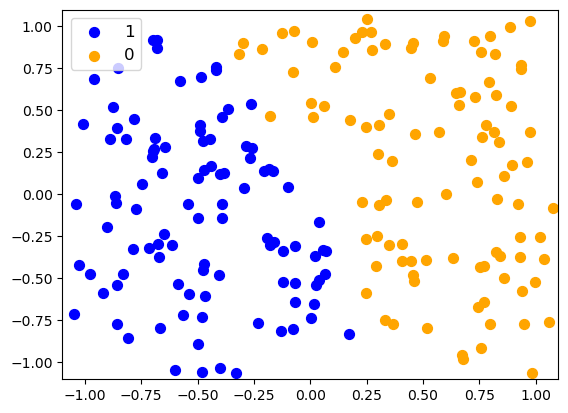

In [258]:
x_train, y_train, x_test, y_test = sample_data('linear-separable')

third_col = np.sum(x_train, axis=1).reshape(-1, 1)
third_col = np.add(np.square(x_train[:, 0]), np.square(x_train[:, 1])).reshape(-1, 1)

third_col = third_col * np.tan(np.sqrt(third_col))
x_train_with_third_col = np.concatenate((x_train, third_col), axis=1)

third_col_test = np.add(np.square(x_test[:, 0]), np.square(x_test[:, 1])).reshape(-1, 1)
third_col_test = third_col_test * np.tan(np.sqrt(third_col_test))
x_test_with_third_col = np.concatenate((x_test, third_col_test), axis=1)

print(x_test_with_third_col[:,:2].shape)
fig = plt.figure()
idx = np.where(y_train==1)[0]
xx  = x_train[idx]
plt.scatter(xx[:, 0], xx[:, 1], color='blue', alpha=1, s=50, label='1')
idx = np.where(y_train == 0)[0]
xx  = x_train[idx]
plt.scatter(xx[:, 0], xx[:, 1], color='orange', alpha=1, s=50, label='0')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1, 1.1)
plt.legend(fontsize=12)
plt.show()

### Train model and visualization

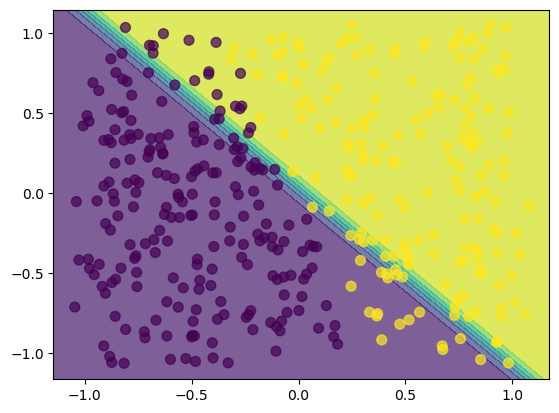

In [281]:
opt_act = 'linear'
opt_init = 'xe'
opt_optimizer = 'adam'
model = mlp([2,5,1], opt_act , opt_init, opt_optimizer)
train_logs = model.train(x_train, y_train, x_test, y_test,learning_rate=0.1, epochs=50,print_every=100, plot_every=100)

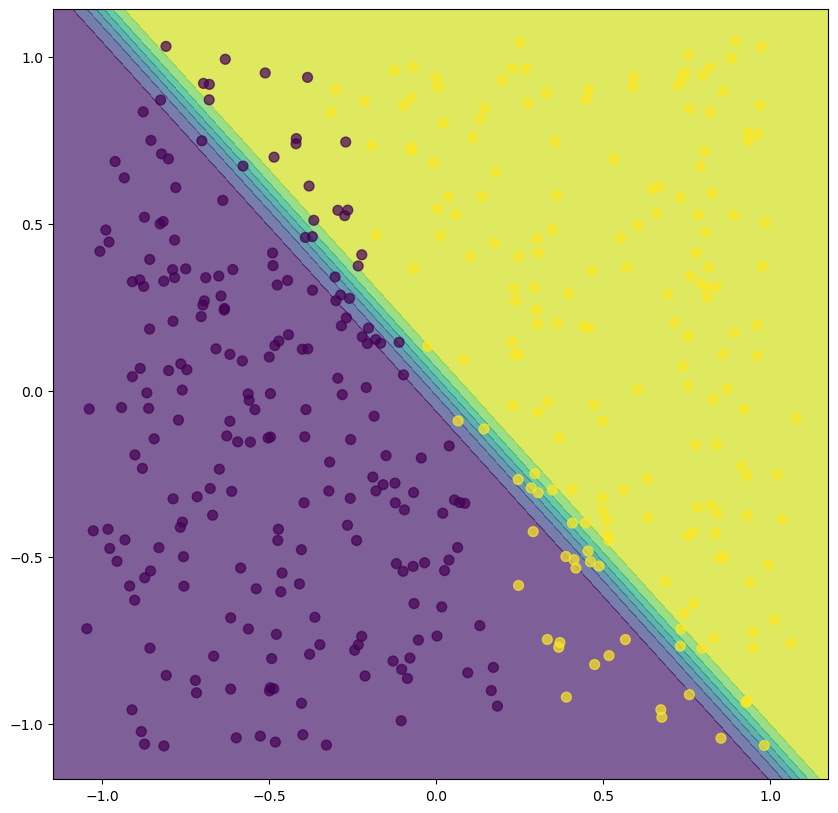

In [282]:
plt.figure(figsize=(10, 10))
X = np.concatenate(
    [x_train_with_third_col, x_test_with_third_col], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, model.predict,boundry_level=None)

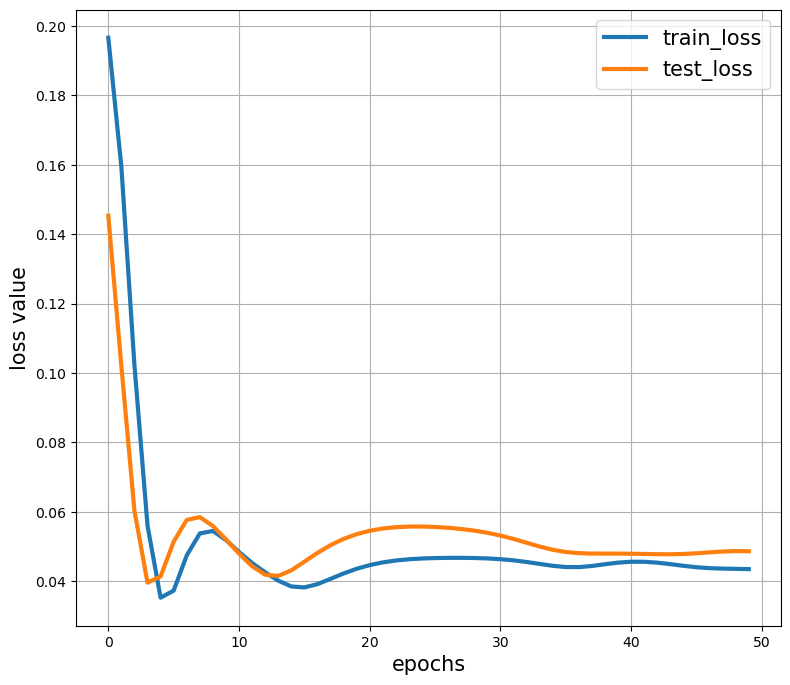

In [283]:
plot_loss(train_logs)